In [6]:
%matplotlib inline
import requests
from itertools import product
import threddsclient
import pydap.client
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
years = list(range(2020,2021))
months = [1] #list(range(1,6)) + list(range(11,13))
urls = []
for y, m in product(years, months): 
    catalog = f'https://thredds.met.no/thredds/catalog/aromearcticarchive/{y:04d}/{m:02d}/catalog.html'
    if requests.get(catalog).status_code == 200: 
        datasets = threddsclient.crawl(catalog, depth=1)
        urls += [ds.opendap_url() for ds in datasets if '_pp_' in ds.name]

In [3]:
ds = pydap.client.open_url(urls[0]) # select the first file and check what is inside

print(ds) # See the available fields

<DatasetType with children 'time', 'forecast_reference_time', 'height_above_msl', 'height0', 'height1', 'height3', 'projection_lambert', 'x', 'y', 'longitude', 'latitude', 'surface_air_pressure', 'relative_humidity_2m', 'x_wind_10m', 'y_wind_10m', 'air_pressure_at_sea_level', 'precipitation_amount_acc', 'wind_speed_of_gust', 'fog_area_fraction', 'land_area_fraction', 'precipitation_amount', 'precipitation_amount_high_estimate', 'precipitation_amount_low_estimate', 'precipitation_amount_middle_estimate', 'precipitation_amount_prob_low', 'cloud_area_fraction', 'high_type_cloud_area_fraction', 'low_type_cloud_area_fraction', 'medium_type_cloud_area_fraction', 'helicopter_triggered_index', 'number_of_tracks', 'strike_probability', 'air_temperature_2m', 'altitude', 'p0'>


In [4]:
# See what time is spanned by each file
timestamp = np.array(ds['time']) 
print("Time steps: ", len(timestamp))
human_readable_time1 = datetime.fromtimestamp(timestamp[0]) # convert to human-readable format
human_readable_time2 = datetime.fromtimestamp(timestamp[-1])
print("initial time {}, final time {}".format(human_readable_time1, human_readable_time2))

Time steps:  4
initial time 2020-01-31 22:00:00, final time 2020-02-01 01:00:00


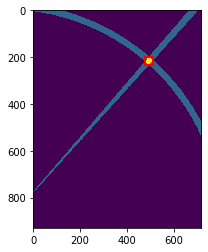

In [7]:
# Find ids for the area of interest
lat1 = np.array(ds['latitude'][:]) < 69.60
lat2 = np.array(ds['latitude'][:]) > 68.99
long1 = np.array(ds['longitude'][:]) < 18.10
long2 = np.array(ds['longitude'][:]) > 16.62
target_area = lat1*lat2*long1*long2
idy, idx = np.where(target_area)

# Plot the area of interest
rect = patches.Rectangle((idx.min(),idy.min()), idx.max()-idx.min(), idy.max()-idy.min(), linewidth=2, edgecolor='r',facecolor='none')
fig,ax = plt.subplots(1)
ax.imshow((lat1*lat2).astype(int) + (long1*long2).astype(int) + (target_area).astype(int))
ax.add_patch(rect)
plt.show()

<GridType with array 'x_wind_10m' and maps 'time', 'height3', 'y', 'x'>


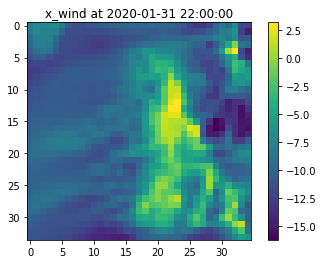

In [8]:
print(ds['x_wind_10m']) # See the data fields of the x_wind
x_wind_arr = np.array(ds['x_wind_10m'][:,:, idy.min():idy.max(), idx.min():idx.max()]).squeeze()
plt.imshow(x_wind_arr[0])
plt.title("x_wind at {}".format(human_readable_time1))
plt.colorbar()

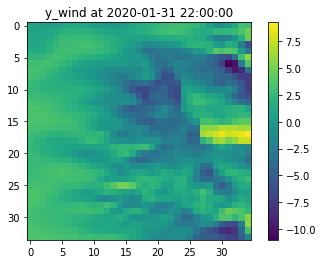

In [9]:
y_wind_arr = np.array(ds['y_wind_10m'][:,:, idy.min():idy.max(), idx.min():idx.max()]).squeeze()
plt.imshow(y_wind_arr[0])
plt.title("y_wind at {}".format(human_readable_time1))
plt.colorbar()